In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

In [ ]:
# !git clone https://github.com/sorki/python-mnist
# !cd python-mnist && ./get_data.sh

In [2]:
log_interval = 50

In [3]:
# torch.manual_seed(args.seed)
# torch.cuda.manual_seed(args.seed)
batch_size = 500


kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./python-mnist/data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./python-mnist/data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [128]:

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 5)
        self.fc22 = nn.Linear(400, 5)
        self.fc3 = nn.Linear(5, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [129]:

model = VAE()
model.cuda()

reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False


def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

In [130]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [131]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [132]:
def test(epoch):
    model.eval()
    test_loss = 0
    for data, _ in test_loader:
        data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [133]:
epochs = 10

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 548.996500
Train Epoch: 1 [25000/60000 (42%)]	Loss: 208.539797
Train Epoch: 1 [50000/60000 (83%)]	Loss: 173.878047
====> Epoch: 1 Average loss: 220.4597
====> Test set loss: 162.1572
Train Epoch: 2 [0/60000 (0%)]	Loss: 163.674531
Train Epoch: 2 [25000/60000 (42%)]	Loss: 150.785531
Train Epoch: 2 [50000/60000 (83%)]	Loss: 146.236406
====> Epoch: 2 Average loss: 152.2442
====> Test set loss: 145.6020
Train Epoch: 3 [0/60000 (0%)]	Loss: 149.097187
Train Epoch: 3 [25000/60000 (42%)]	Loss: 143.350016
Train Epoch: 3 [50000/60000 (83%)]	Loss: 142.126703
====> Epoch: 3 Average loss: 143.4190
====> Test set loss: 140.3428
Train Epoch: 4 [0/60000 (0%)]	Loss: 144.656906
Train Epoch: 4 [25000/60000 (42%)]	Loss: 139.914484
Train Epoch: 4 [50000/60000 (83%)]	Loss: 135.527891
====> Epoch: 4 Average loss: 139.4823
====> Test set loss: 137.3607
Train Epoch: 5 [0/60000 (0%)]	Loss: 137.533547
Train Epoch: 5 [25000/60000 (42%)]	Loss: 139.560141
Train Epoch: 5 [50000/600

In [134]:
from matplotlib import pyplot as plt
%matplotlib inline
import holoviews as hv
hv.notebook_extension()

:DynamicMap   [u0,u1,u2,u3,u4]
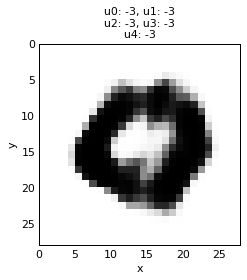

In [135]:
%opts Raster style(cmap='Greys')

def draw(*args):
    x = torch.cuda.FloatTensor([args])
    inp = x.cuda()
    var = Variable(inp)
    out = model.decode(var)
    data = out.data.cpu().numpy()[::-1].reshape(28,28)
    return hv.Raster(data)

dims = [hv.Dimension('u'+str(i), range=(-3.0, 3.0)) for i in range(5)]

dmap = hv.DynamicMap(draw, kdims=dims)
dmap

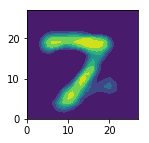

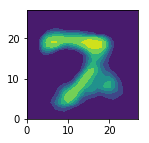

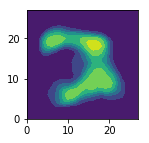

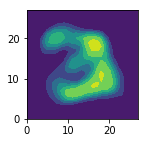

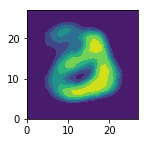

In [415]:
# inp = torch.randn(1, 20)
# inp = x.cuda()
# var = Variable(inp)
# out = model.decode(var)

for i in range(-30, 30, 12):
    x = torch.cuda.FloatTensor([[i*0.1,1,1,1,1,1,1,1,1,1]])
    inp = x.cuda()
    var = Variable(inp)
    out = model.decode(var)
    plt.figure(figsize=(2,2))
    plt.contourf(out.data.cpu().numpy()[::-1].reshape(28,28)[::-1])
    plt.show()

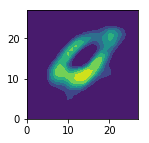

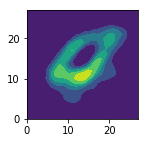

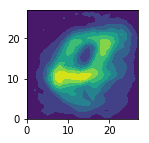

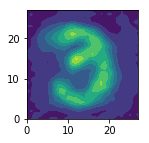

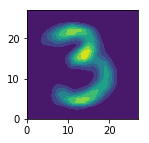

In [421]:
for i in range(-30, 30, 12):
    x = torch.cuda.FloatTensor([[0,i*0.1,0,0,0,0,0,0,0,0]])
    inp = x.cuda()
    var = Variable(inp)
    out = model.decode(var)
    plt.figure(figsize=(2,2))
    plt.contourf(out.data.cpu().numpy()[::-1].reshape(28,28)[::-1])
    plt.show()

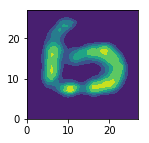

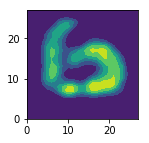

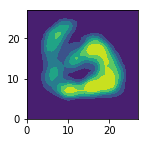

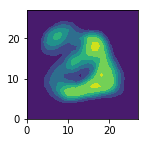

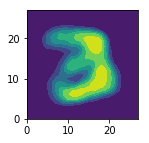

In [417]:
for i in range(-30, 30, 12):
    x = torch.cuda.FloatTensor([[1,1,1,1,1,1,1,1,i*0.1,1]])
    inp = x.cuda()
    var = Variable(inp)
    out = model.decode(var)
    plt.figure(figsize=(2,2))
    plt.contourf(out.data.cpu().numpy()[::-1].reshape(28,28)[::-1])
    plt.show()

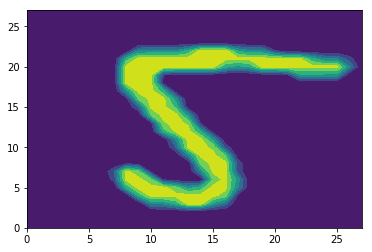

In [343]:
plt.contourf(test_loader.dataset.test_data[1].numpy())

In [348]:
data = list(test_loader)[0][0][9]

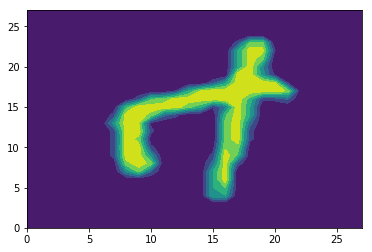

In [349]:
plt.contourf(data.numpy().reshape(28,28))

In [350]:
out = model(Variable(torch.cuda.FloatTensor(data.numpy().tolist())))

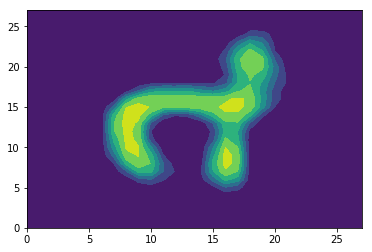

In [351]:
plt.contourf(out[0].data.cpu().numpy().reshape(28,28))

In [358]:
model.encode(Variable(torch.cuda.FloatTensor(data.numpy().tolist())).view(-1, 784))

(Variable containing:
 
 Columns 0 to 9 
  0.7895 -0.4719  0.1194 -0.5975 -0.9674 -0.6017 -1.5612  2.0744  0.0767  1.5191
 
 Columns 10 to 19 
  0.9802 -0.0007 -0.3848 -0.0619  0.7126 -0.0079  1.4639 -0.1524 -0.1495 -1.2194
 [torch.cuda.FloatTensor of size 1x20 (GPU 0)], Variable containing:
 
 Columns 0 to 9 
 -1.9599 -2.5054 -1.1486 -1.7280 -2.6575 -2.1807 -3.2635 -2.7610 -1.4370 -1.8918
 
 Columns 10 to 19 
 -3.1831 -1.7227 -2.5745 -2.7213 -2.4159 -1.4358 -1.5198 -2.6529 -1.9413 -3.1022
 [torch.cuda.FloatTensor of size 1x20 (GPU 0)])